In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.bag as db
import tqdm 

from distributed import Client
from dask_jobqueue import SLURMCluster
from IPython.display import display

import os
from glob import glob

In [2]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='256GB', cores=8, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

/ext3/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43987 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:41031 Dashboard: http://127.0.0.1:43987/status,Cluster Workers: 4 Cores: 4 Memory: 34.36 GB


In [3]:
os.chdir('/scratch/work/courses/DSGA1004-2021/movielens/ml-latest-small')

In [4]:
# Import the ratings dataset
ratings_df = pd.read_csv('ratings.csv').sort_values(by="timestamp").reset_index(drop=True)
print("This dataset contains {} rows and {} columns.".format(ratings_df.shape[0], ratings_df.shape[1]))
ratings_df.head()

This dataset contains 100836 rows and 4 columns.


,userId,movieId,rating,timestamp
0,429,595,5.0,828124615
1,429,588,5.0,828124615
2,429,590,5.0,828124615
3,429,592,5.0,828124615
4,429,432,3.0,828124615


Split each user's data into training-validation-test set. For each user, use 60% of their ratings for training, 20% for validation, and 20% for testing.

In [5]:
# For each user, compute the number of ratings they submitted
num_ratings_per_user = ratings_df.groupby('userId').count()['rating']

In [6]:
# TO-DO: Will need to optimize this algorithm - it's quite slow
# Create training, validation, and test sets for each user
training_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for userId, num_ratings in tqdm.tqdm_notebook(list(zip(num_ratings_per_user.index, num_ratings_per_user))):
    # Get all the ratings for this user
    user_ratings = ratings_df[ratings_df['userId'] == userId].reset_index(drop=True)
    
    # Make the first 60% of this user's ratings the training set
    index_train = int(0.6*num_ratings)
    user_train = user_ratings.loc[:index_train-1, :]
    
    # Make the next 20% of this user's ratings the validation set
    index_val = index_train + int(0.2*num_ratings)
    user_val = user_ratings.loc[index_train:index_val-1, :]
    
    # Make the last 20% of this user's ratings the testing set
    user_test = user_ratings.loc[index_val:, :]
    
    # Add this user's individual training, validation, and testing sets to the
    # unified training, validation, and testing sets, respectively
    training_df = pd.concat([training_df, user_train], axis=0)
    val_df = pd.concat([val_df, user_val], axis=0)
    test_df = pd.concat([test_df, user_test], axis=0)

<ipython-input-6-937904a1c4d9>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, num_ratings in tqdm.tqdm_notebook(list(zip(num_ratings_per_user.index, num_ratings_per_user))):


  0%|          | 0/610 [00:00<?, ?it/s]

In [7]:
# Sanity check (these two should match)
print(num_ratings_per_user.sum()) # total number of ratings
print(sum([len(training_df), len(val_df), len(test_df)]))

100836
100836


# Baseline Model

Compute the mean rating of each movie by grouping by movieId, and aggregating by mean. Note that we don't want to explicitly compute the utility matrix, because doing so will take a very long time, and the resulting matrix will be very large and take up a lot of memory.

We compute the 100 highest mean-rated movies from the training set. We will recommend these 100 movies to every single user in the validation set.

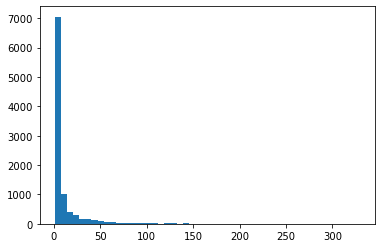

In [8]:
plt.hist(ratings_df.groupby('movieId').count()['userId'], bins=50)
plt.show()

WE SHOULD CHOOSE THE THRESHOLD DEPENDING ON OUR DATASET SIZE

In [9]:
# Count the number of ratings for each movie
num_ratings_per_movie = ratings_df.groupby("movieId").count()["rating"]

# Only keep movies with at least 20 ratings (e.g. we don't want to treat a movie that was rated 5 stars by too few people to be considered popular)
ratings_df = ratings_df.join(num_ratings_per_movie, on = "movieId", rsuffix="_count")
ratings_df = ratings_df[ratings_df["rating_count"] >= 20]

In [10]:
mean_ratings = ratings_df[["movieId", "rating"]].groupby("movieId").mean()["rating"]
mean_ratings = mean_ratings.sort_values(ascending=False)
R_i = np.array(mean_ratings.head(100).index)
print(R_i)

[  1104    318    922    898    475   1204    246    858   1235 168252
   2959   1276    750    904   1221  48516   1213    930   1267    912
  58559     50   1197    260   1212    926   1245    527   3275   1208
    933   2329   1196   1233   1252   1198   1193   1089    296   2571
   2019   1228   1945   1225    908   4973   1199   2160   1242    913
    356   1172   1136    593   7361  57669   4011   5618   3681   1203
   3147    741   2324   6016   2028   1201   3037  56782   2067   1210
  68157   1262   4226   1250   1272   1207   7153  44555    608   1266
  78499   5995  92259   4993   1244    111    541   1086   1222    720
   2502  27773   1223   1258   1704   1673  31658    899  38061   1249]


In [11]:
val_df = val_df.sort_values("rating", ascending=False)
val_df

,userId,movieId,rating,timestamp
81,542,7254,5.0,1163387790
35,267,260,5.0,959815004
129,80,86190,5.0,1377309155
37,267,919,5.0,959815004
141,520,2423,5.0,1326611163
...,...,...,...,...
395,219,546,0.5,1195944991
74,83,4720,0.5,1333842166
300,517,2683,0.5,1487958167
1197,448,82095,0.5,1322404967


## Recommendation Algorithm

In [12]:
# Initialize array of relevances
users = val_df['userId'].unique()
n_users = len(users)
n_recs = 100 # number of recommendations
rel_D = pd.DataFrame(np.empty(shape=(n_users, n_recs)), index=users, columns=R_i)

In [13]:
# Split the validation data into multiple dataframes, where each dataframe contains validation data for one user
# Then get the movieId's that each user rated (from highest to lowest rating), where D[i] contains the movieIds that user i rated
val_df_group = val_df.groupby("userId")
D = list(map(lambda user: val_df_group.get_group(user)["movieId"].values[0:100], users))

# For each user, compute relevance
# rel_D[u, m] = 1 if recommended movie m is relevant to user u and 0 otherwise
rel_D[:] = np.row_stack(list(map(lambda D_i: np.isin(R_i, D_i).astype(int), D)))
rel_D

,1104,318,922,898,475,1204,246,858,1235,168252,...,2502,27773,1223,1258,1704,1673,31658,899,38061,1249
542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
442,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Compute precision at k=100
k = 100
precision = np.mean(np.sum(rel_D, axis=1) / k)
print(precision)

0.022114754098360553


### Questions

* Should we be constructing our baseline model using the whole dataset or only the training set?